# 2018-10-08 : Biologicaly realist ring with working STDP
Allez on y croit cette fois-ci il va marcher

Il faudrait que j'implémente les synapses inhibitrices qui ont aussi leurs STDP, même si j'y croyais pas trop ça existe et c'est plutot solide (Neuron publication : https://www.ncbi.nlm.nih.gov/pubmed/25843405).

Ca marche pas ici parce que la tuning function sort des valeurs tout le temps positif pour les poids synaptiques et la STDP a besoin d'être dans le meme sens que la synapse, donc négatif pour les inhibiteurs. A rajouter plus tard donc.

In [1]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
import numpy as np
import matplotlib.pyplot as plt
from pyNN.utility.plotting import Figure, Panel

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# Scanning synaptic delay

In [2]:
def Modified_VanillaRasterPlot( SpikesP, SpikesE, SpikesI,param_scan, spike_thresh, title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
        
            
        fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = figsize)
        plot_spiketrains(axs[0], SpikesP, color = 'r', ylabel = 'Neuron Index', do_ticks = False)
        axs[0].set_title('Poisson input #1')
        plot_spiketrains(axs[1], SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs[1].set_title('Poisson input #2')
        
        axs[2].plot(SpikesE.analogsignals[0].times, SpikesE.analogsignals[0])
        axs[2].set_ylabel('Voltage')
        axs[2].axhline(spike_thresh, color = 'k', linestyle = '-.')
        axs[2].set_title('Single STDP neuron ')
        
        plt.xlabel('Time(ms)')
        fig.suptitle('Synaptic delay = %s ms' % param_scan, fontsize=12)
        
        return fig, axs
        
        
def spike_chunk_detector(signal, threshold, timeframe, verbose = False):
    '''
    On a given analogsignal array, detects pseudo-spikes by clustering above-threshold times
    into groups, given a timeframe(ms) and a threshold(mV)
    
    Ideal timeframes are approx. that of the oscillation period of the network
    '''
    
    #working lists
    chunking_list = []
    chunk_list = []
    
    trues = (signal>threshold)
    
    for it, a in enumerate(trues):
        if a == True : 
            #print(post_v.analogsignals[0].times[it])
            chunking_list.append(sig.times[it])
            
    chunking_list = np.squeeze(chunking_list)
    for it, a in enumerate(chunking_list):
        if it > 5 and chunking_list[it-1]+timeframe < chunking_list[it]: #discard first few hits to be safe on initialisation nois
            chunk_list.append(chunking_list[it-1])
            if verbose : print('Found cluster at %s ms' % chunking_list[it-1])
                
    if verbose : print('Found total of %s cluster(s)' % len(chunk_list))
    return chunk_list

In [3]:
class Net_Parameters :
    def __init__(self, ring=True, recurrent=False, seed=42, source='poisson', comult = 1):
        self.seed = seed
        self.source = source
        self.recurrent = recurrent
        self.ring = ring
        self.comult = comult #connection sparseness multiplicativity, for easier tuning


        #c : connectivity probability
        #w : global weight, value for every connections
        #i_rate : input rate, mean firing rate of source population neurons
        #w_in : weight of connections between source population and excitatory neurons population
        #s : synaptic delay
        #g : inhibition-excitation coupling
        #p : excitatory neurons percentage in network
        #n_model : neuron dynamic model
        #b_input : input orientation distribution bandwidth
        #angle_input : the most represented orientation angle in input distribution
        #b_xx : orientation selectivity for a projection xx
        '''
        Parameters : Network parameters, Neuron parameters, Simulation parameters,
        '''
        #a.General network params
        #Ring network
        if self.ring:
            self.c = 1. #doesnt do anything now
            if self.recurrent :
                self.w, self.w_inh, w_input_exc = .2, .3, .3
                self.g = 3.
            else:
                self.w, self.w_inh, w_input_exc = .1, .0, .3
                self.g = 0.
        #Non ring network
        else:
            self.c = 0.15
            if self.recurrent :
                self.w, self.w_inh, w_input_exc = .25, .2, .3
                self.g = 1.
            else:
                self.w, self.w_inh, w_input_exc = .0, .0, .3
                self.g = 0.
                
        #b.Point neuron params        
        self.exc_params = {'cm': .5, #nF - McCormick
             'e_rev_E': 0.0, #mV - McCormick but default values
             'e_rev_I': -70.0, #mV - McCormick but default values
             'tau_m': 30, #ms - Markram
             'tau_refrac': 1.5, #ms - McCormick
             'tau_syn_E': 0.25, #ms -McCormick
             'tau_syn_I': 0.75, #ms - McCormick
             'v_reset': -56.5, #mV - McCormick
             'v_rest': -73.6, #mV - McCormick
             'v_thresh': -52.5 #mV - McCormick
                          }

        self.inh_params = {'cm': .214, #nF - McCormick
             'e_rev_E': 0.0, #mV - McCormick but default values
             'e_rev_I': -70.0, #mV - McCormick but default values
             'tau_m': 21, #ms - Markram
             'tau_refrac': 1.0, #ms - McCormick
             'tau_syn_E': 0.25, #ms -McCormick
             'tau_syn_I': 0.75, #ms - McCormick
             'v_reset': -57.8, #mV - McCormick
             'v_rest': -74.5, #mV - Markram, McCormick uses another celltype that's known for not spiking a lot
             'v_thresh': -52.5 #mV - McCormick
                          }
        
        #c.Simulation params
        self.sim_params = {
        'simtime'     : 1000,   #(ms)
        'input_rate'  : 10.,   #(Hz)
        'b_input'     : np.inf,#infinite
        'angle_input' : 90,    #degrees
            
        #params for the angles shifts
        'nb_shifts' : 6, #number of time the angles are shifting, as in next call at t + simtime/nb_shifts
        'mag_shifts' : 100, #magnitude of the shift, as in angle = t/magshift * (regular angle formula)

        'nb_neurons'  : 1000,  #neurons number
        'p'           : .8,        #excitatory rate in the population
        'neuron_model': 'IF_cond_alpha',    #point neuron model
        #'v_init_min'   : -53.5,  # (mV)
        #'v_init_max'   : -49.75,  # (mV)

        #'c_input_exc' : 1., #self.c*10,
        'c_input_inh' : 0, #self.c*0.,
        'w_input_exc' : w_input_exc,
        
        #delays in ms
        's_input_exc' : 1,
        's_input_inh' : 1,
        's_exc_inh'   : 1,
        's_inh_exc'   : 1,
        's_exc_exc'   : 1,
        's_inh_inh'   : 1,
        'sigma' : .2, #sigma value for normal distribution of synaptic delays
            
        #B_thetas for the ring ?
        'b_exc_inh'   : np.inf,
        'b_exc_exc'   : np.inf,
        'b_inh_exc'   : np.inf,
        'b_inh_inh'   : np.inf,
        
        #connectivity patterns, see Markram
        'c_exc_inh'   : 0.07*self.comult, #PC to NBC
        'c_inh_exc'   : 0.06*self.comult, #NBC to PC
        'c_exc_exc'   : 0.08*self.comult, #PC to PC
        'c_inh_inh'   : 0.05*self.comult, #NBC to NBC

        #synaptic weight (µS)
        'w_exc_inh'   : self.w*self.g,
        'w_inh_exc'   : self.w_inh,
        'w_exc_exc'   : self.w,
        'w_inh_inh'   : self.w_inh*self.g,
        }
        
        #optimized params for ring
        if self.ring :
            self.sim_params['b_input'] = 45.
            self.sim_params['b_exc_inh'] = 20.
            self.sim_params['b_exc_exc'] = 20.
            self.sim_params['b_inh_exc'] = 20.
            self.sim_params['b_inh_inh'] = 20.
            
#    def return_params(self):
#        return (self.sim_params)

In [4]:
sim.AdditiveWeightDependence.default_parameters

{'w_min': 0.0, 'w_max': 1.0}

In [5]:
from joblib import Parallel, delayed

class RNN_Simulation:
    def __init__(self, sim_params=None, inh_params=None, exc_params=None, verbose = True):
        '''
        Parameters : Stimulus, Population, Synapses, Recording, Running 
        '''
        self.verbose = verbose
        self.sim_params = sim_params
        self.inh_params = inh_params
        self.exc_params = exc_params
        
        sim.setup(spike_precision = 'on_grid')#spike_precision='on_grid')#timestep = .1)
        
        N_in = int(sim_params['nb_neurons']*sim_params['p']) #total pop * proportion of inhib
        prog_rate = sim_params['input_rate']
        self.spike_source = sim.Population(N_in, sim.SpikeSourcePoisson(rate=prog_rate,
                                                                        duration=sim_params['simtime']),
                                          label = 'Input')
        
        #orientation stimulus, see bottom section of notebook
        angle = 1. * np.arange(N_in)
        rates = self.tuning_function(angle, sim_params['angle_input']/180.*N_in, sim_params['b_input'], N_in)
        rates /= rates.mean()
        rates *= sim_params['input_rate']
        for i, cell in enumerate(self.spike_source):
            cell.set_parameters(rate=rates[i])
        
        #neuron model selection
        if sim_params['neuron_model'] == 'IF_cond_alpha':
            model = sim.IF_cond_alpha #LIF with nice dynamics
        else: 
            model = sim.IF_cond_exp #LIF with exp dynamics
        
        rng = sim.NumpyRNG(seed = 42)
        #populations, reminder that E_neurons is the same size as the spike source(N_in)
        E_neurons = sim.Population(N_in, 
                                   model(**exc_params),label="Excitateurs")                         
        I_neurons = sim.Population(int(sim_params['nb_neurons'] - N_in),
                                   model(**inh_params),label="Inhibiteurs")

        #input to excitatories
        self.input_exc = sim.Projection(self.spike_source, E_neurons,
                                sim.FixedProbabilityConnector(.05),# rng=sim.NumpyRNG(seed=42),
                                sim.StaticSynapse(weight=sim_params['w_input_exc'], delay=sim_params['s_input_exc'])
                                )
        
        #loop through connections type and use associated params, can be a bit slow
        conn_types = ['exc_inh', 'inh_exc', 'exc_exc', 'inh_inh']   #connection types
        '''
        self.proj = self.set_synapses(conn_types = conn_types, sim_params =sim_params, 
                                      E_neurons = E_neurons, I_neurons = I_neurons, 
                                      N_inh = N_inh)
        '''
        #Multi threading support NE MARCHE PAS LAISSER LE NJOBS EN 1
        self.proj = Parallel(n_jobs =1, backend = 'multiprocessing')(delayed(self.set_synapses)(conn_type,sim_params =sim_params, 
                                      E_neurons = E_neurons, I_neurons = I_neurons, 
                                      N_in = N_in, conn_types = conn_types) for conn_type in range(len(conn_types)))
        if verbose :print('Done building synapses !')
            
        #record
        self.spike_source.record('spikes')
        E_neurons.record('spikes')
        I_neurons.record('spikes')
        
        #run
        if verbose : print('Running simulation..')
        self.shift_times = [] #a list of shift times with append done in vary_angle
        self.i = 1 #shift iterator
        sim.run_until(sim_params['simtime'], callbacks=[self.vary_angle])
        if verbose : print('Done running !')
        
        #get the spikes
        self.E_neurons = E_neurons#.get_data().segments[0]
        self.I_neurons = I_neurons#.get_data().segments[0]
        self.P_neurons = self.spike_source#.get_data().segments[0]
    
    #run callback function that changes the input angle every 
    def vary_angle(self, t):
        #wanky trick that allows me to leave N_in as a non-self var
        N_in = int(self.sim_params['nb_neurons']*self.sim_params['p']) 
        
        arg_rates = (self.i*self.sim_params['angle_input']/180.*N_in*.5)
        
        angle = 1. * np.arange(N_in)
        rates = self.tuning_function(angle,arg_rates,self.sim_params['b_input'], N_in)
        rates /= rates.mean()
        rates *= self.sim_params['input_rate']
        for i, cell in enumerate(self.spike_source):
            cell.set_parameters(rate=rates[i])
            
        if self.verbose : print('At sim time %s ,current maximum angle %s' % (t, arg_rates ))
        self.shift_times.append(t)
        self.i+=1
        return t + int(self.sim_params['simtime']/self.sim_params['nb_shifts'])

    def set_synapses(self, conn_type, sim_params, E_neurons, I_neurons, N_in, conn_types):
        syn = {}
        proj = {}

        if self.verbose : print('Building %s synapses..' % conn_types[conn_type])
        weight = sim_params['w_{}'.format(conn_types[conn_type])]
        rng = sim.NumpyRNG(seed = 42)
        delay = rnd('normal_clipped', mu=sim_params['s_{}'.format(conn_types[conn_type])],
                                                           sigma=sim_params['sigma'], low = 0.1, 
                   high = 100,
                   rng = rng)
        
        #delay=sim_params['s_{}'.format(conn_types[conn_type])]
        
        if conn_types[conn_type][:3]=='exc': #Excitatory presynapse
            pre_neurons = E_neurons
            receptor_type='excitatory'
            syn[conn_types[conn_type]] = sim.STDPMechanism(
                                                timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                    A_plus=0.9, A_minus=0.9),
                                                weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=1),
                                                weight=0,
                                                delay=delay,
                                                dendritic_delay_fraction=1.)
            if self.verbose : print('Synapse is STDP-enabled')
        else:
            pre_neurons = I_neurons #Excitatory presynapse
            receptor_type='inhibitory'
            syn[conn_types[conn_type]] = sim.StaticSynapse(delay = delay)
            if self.verbose : print('Synapse is static')
            
        if conn_types[conn_type][-3:]=='exc': #To exc
            post_neurons = E_neurons
        else:
            post_neurons = I_neurons #To inh

        sparseness = sim_params['c_{}'.format(conn_types[conn_type])]

        proj[conn_types[conn_type]]  = sim.Projection(pre_neurons, post_neurons,
                                        connector=sim.FixedProbabilityConnector(sparseness, rng=sim.NumpyRNG(seed=42)),
                                        synapse_type=syn[conn_types[conn_type]],
                                        receptor_type=receptor_type)
        bw = sim_params['b_{}'.format(conn_types[conn_type])]
        angle_pre = 1. * np.arange(proj[conn_types[conn_type]].pre.size)
        angle_post = 1. * np.arange(proj[conn_types[conn_type]].post.size)
        w_ij = self.tuning_function(angle_pre[:, np.newaxis], angle_post[np.newaxis, :], bw, N_in)*weight
        if conn_types[conn_type][3:] != 'inh': proj[conn_types[conn_type]].set(weight=w_ij)

        
        return proj
        
    def tuning_function(self, i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM

In [6]:
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt

class PlotTwist:
    def __init__(self, sim_params = None, cell_params = None, verbose = True):
        self.verbose = verbose
        self.sim_params = sim_params
        self.cell_params = cell_params
        
    #RasterPlot using  pyNN    
    def RasterPlot(self, SpikesP, SpikesE, SpikesI, title = 'Title', markersize = .5):
        fig = Figure(
            Panel(SpikesP.spiketrains, xticks = False, ylabel = 'Input', color = 'k', markersize = markersize),
            Panel(SpikesE.spiketrains, xticks = False, ylabel = 'Excitatory', color = 'r', markersize = markersize),
            Panel(SpikesI.spiketrains, xticks = True, xlabel = 'Time(ms)', ylabel = 'Inhibitory',
                  color = 'b', markersize = markersize),
            title = title, settings = {'figure.figsize': [9., 6.]})
        
        '''for ax in fig.fig.axes:
            ax.set_xticks(np.linspace(0, self.sim_params['simtime'], 6, endpoint = True))'''
        fig.fig.subplots_adjust(hspace = 0)
        return fig
    
    def VanillaRasterPlot(self, SpikesP, SpikesE, SpikesI, title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
            
        fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = figsize)
        plot_spiketrains(axs[0], SpikesP, color = 'k', ylabel = 'Neuron Index', do_ticks = False)
        axs[0].set_title('Poisson input')
        plot_spiketrains(axs[1], SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs[1].set_title('Inhibitory population')
        plot_spiketrains(axs[2], SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs[2].set_title('Excitatory population')
        plt.xlabel('Time(ms)')
        fig.suptitle(title, fontsize=12)
        return fig, axs
        
    #TODO finish this method
    def OneParamVar_RasterPlot(self, spikesP, spikesE, spikesI, title = 'Title', markersize = .5,
                              var_name = None, var_values = None, force_int = False):
        '''
        var_name is the variable name as it is in sim_param (otherwise it won't work)
        '''
        if force_int : values = [int(i) for i in values]
        
        for i, value in enumerate(var_values):
            sim_params[var_name] = value
            self.RasterPlot(SpikesP, SpikesE, SpikesI, title = 'Variable %s : %s' %(var_name, value))

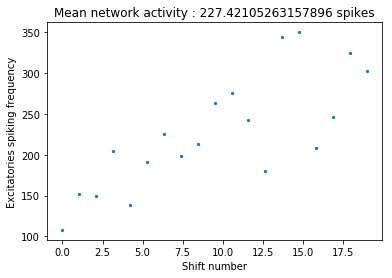

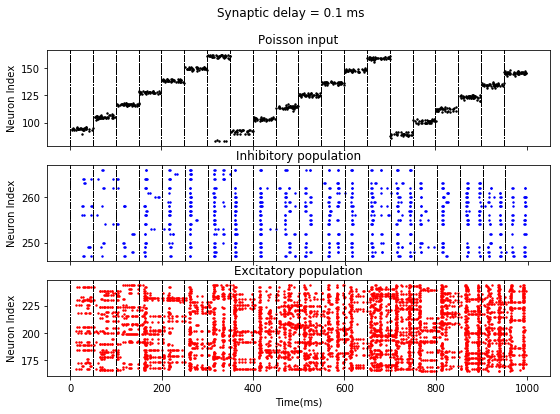

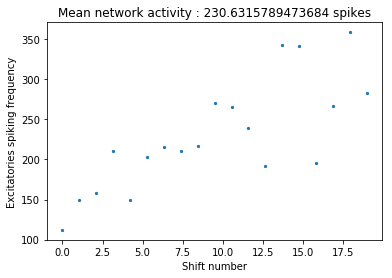

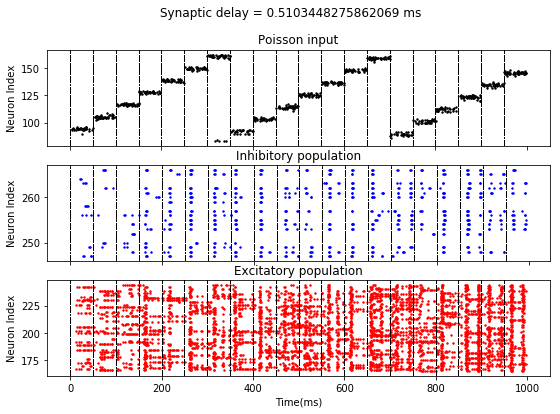

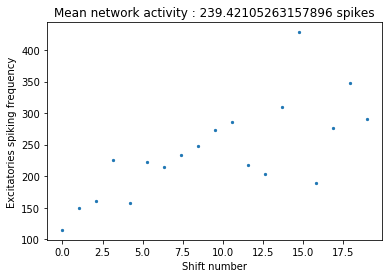

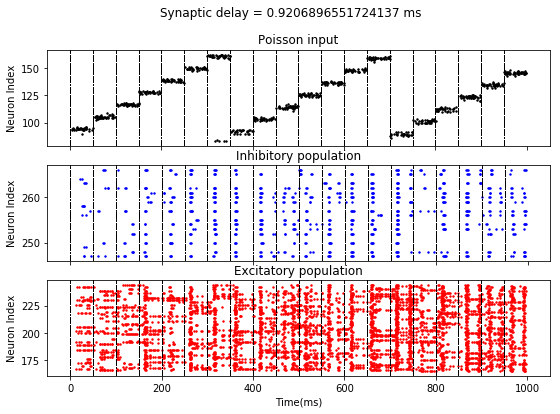

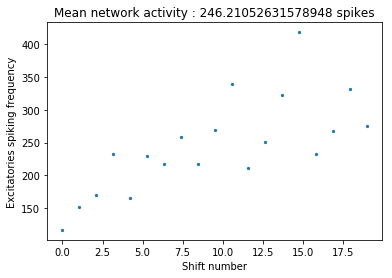

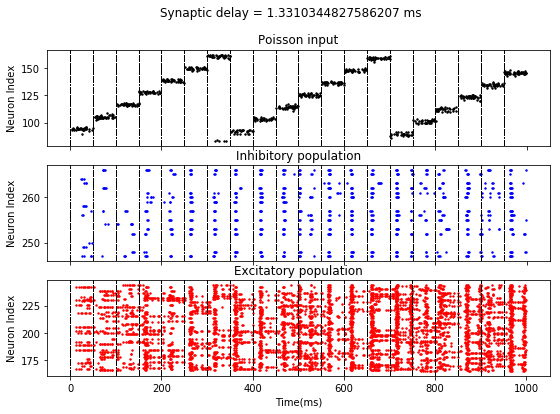

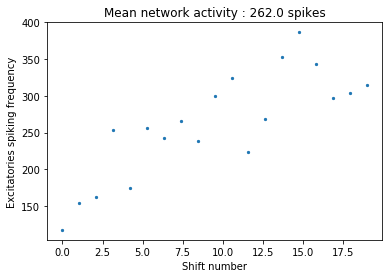

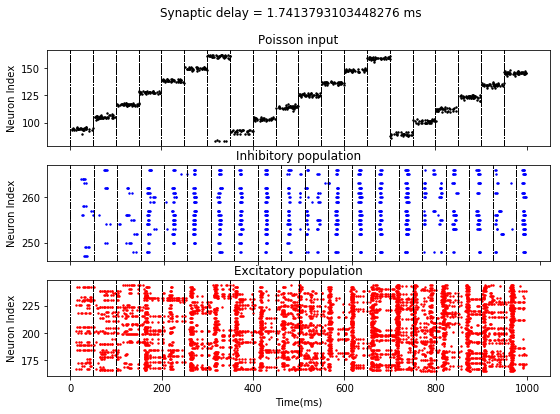

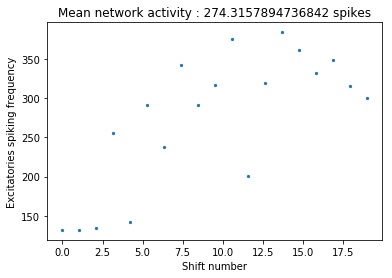

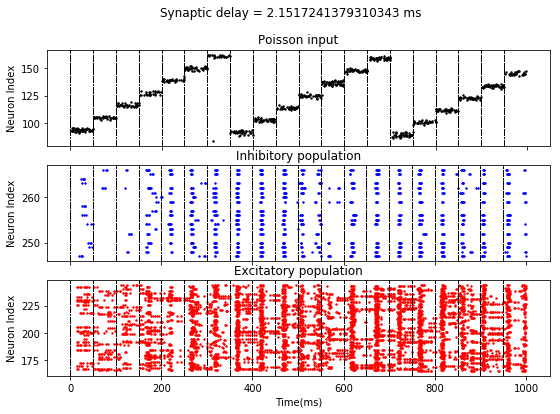

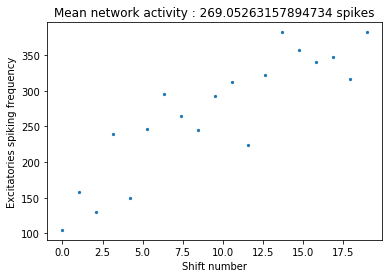

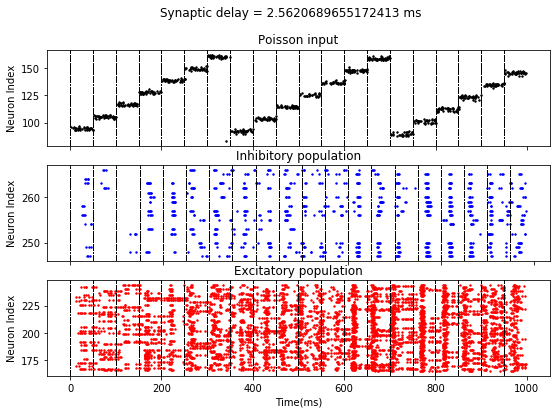

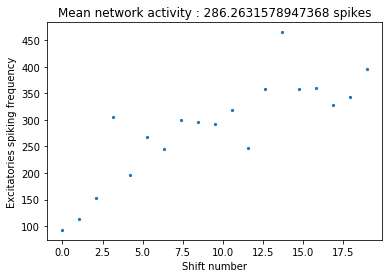

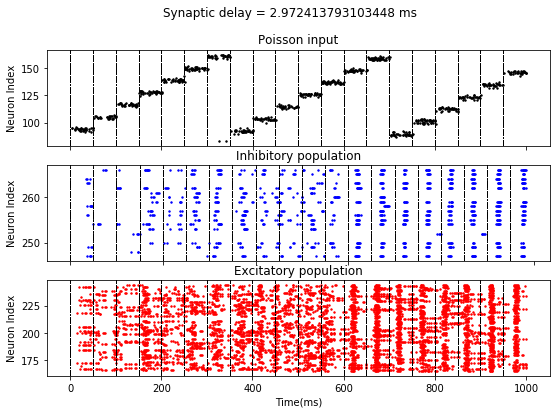

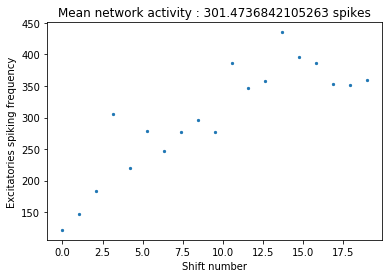

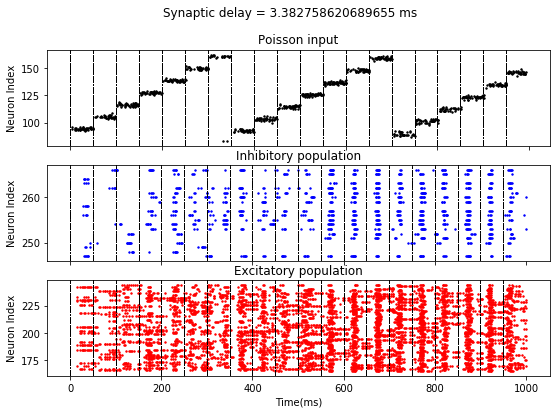

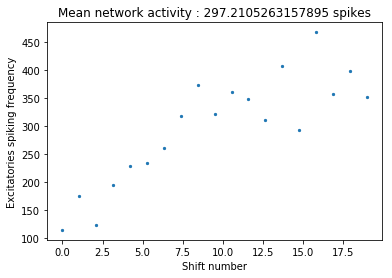

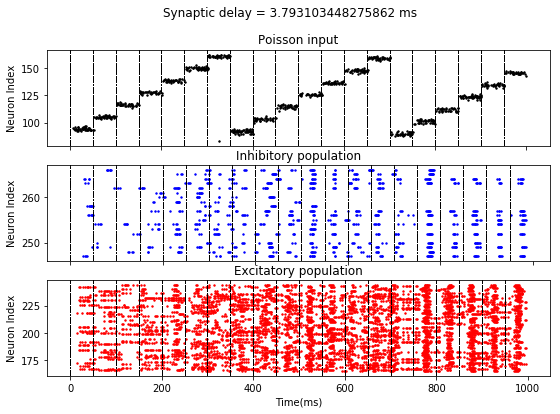

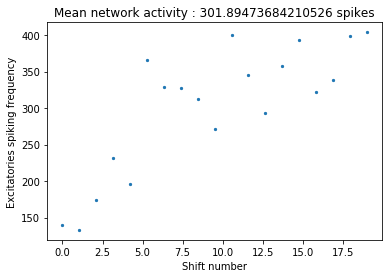

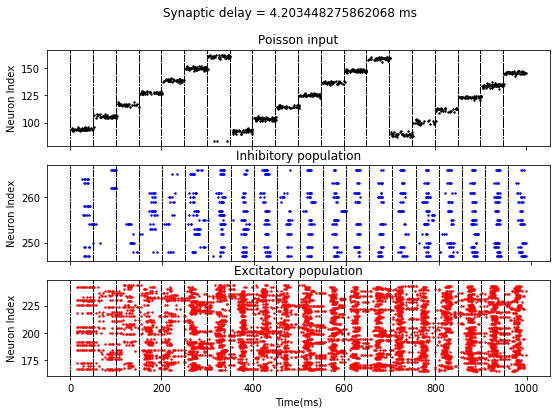

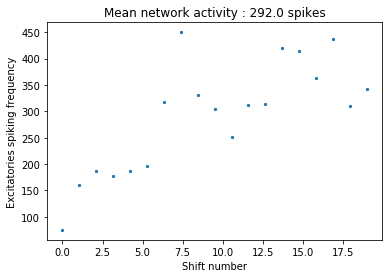

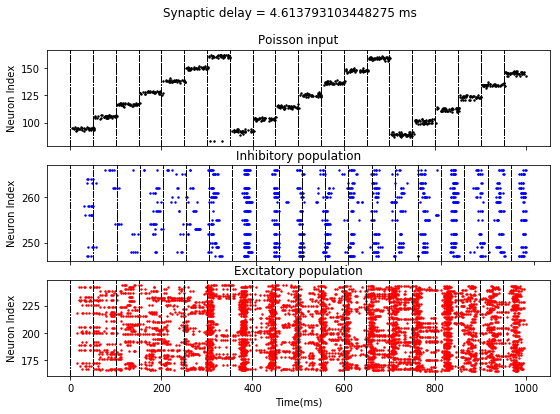

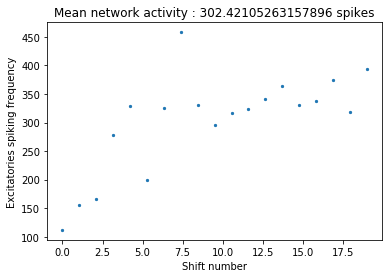

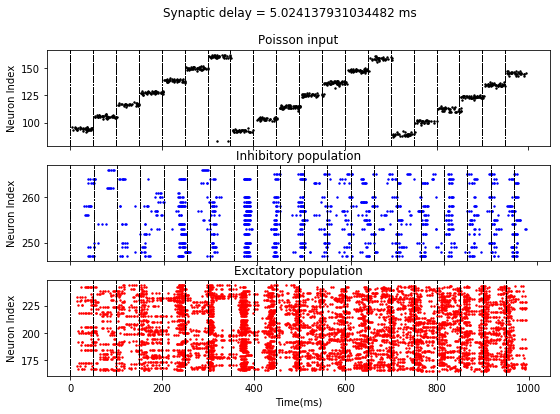

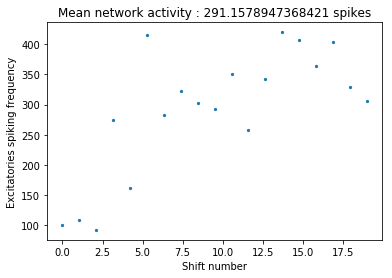

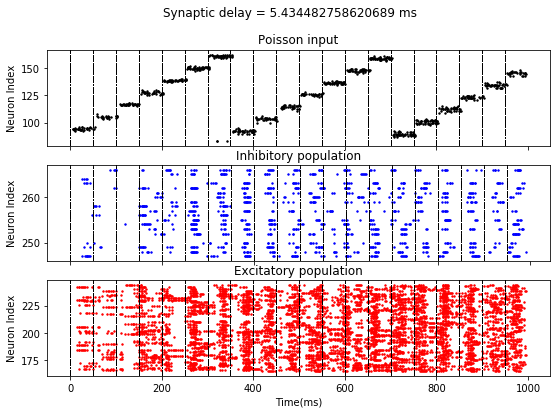

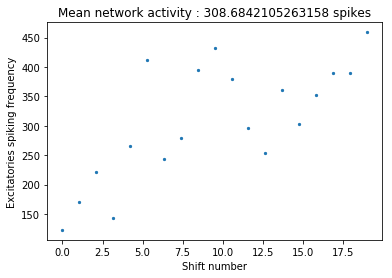

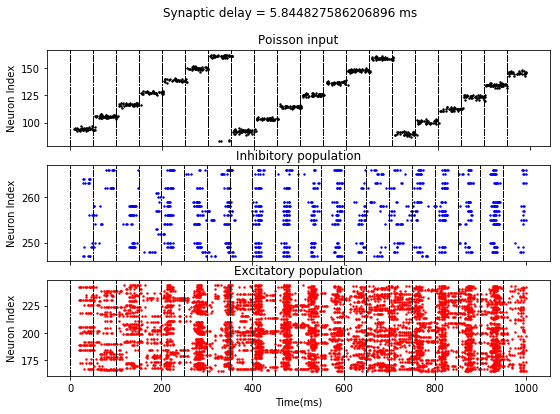

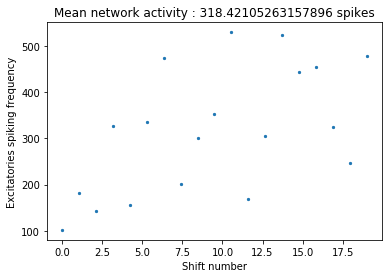

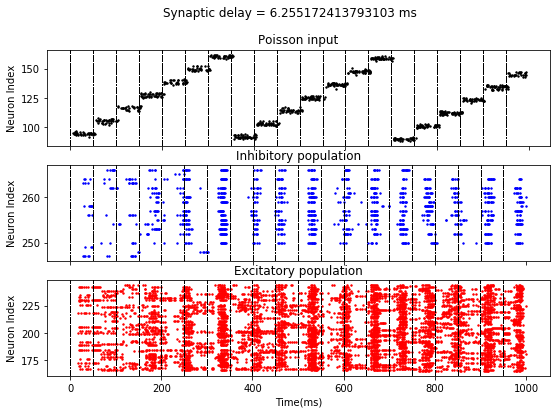

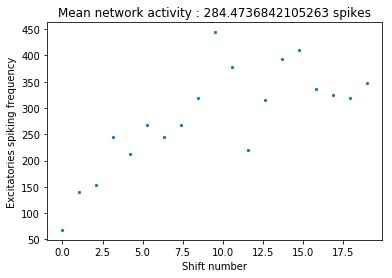

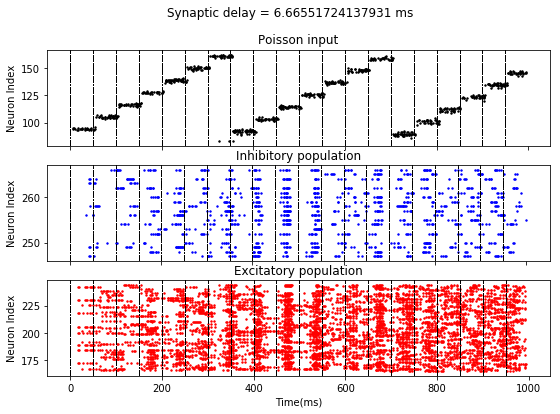

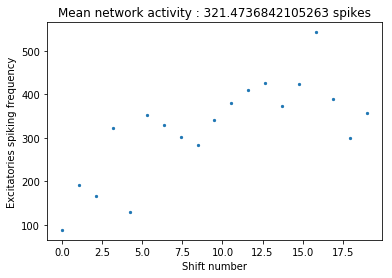

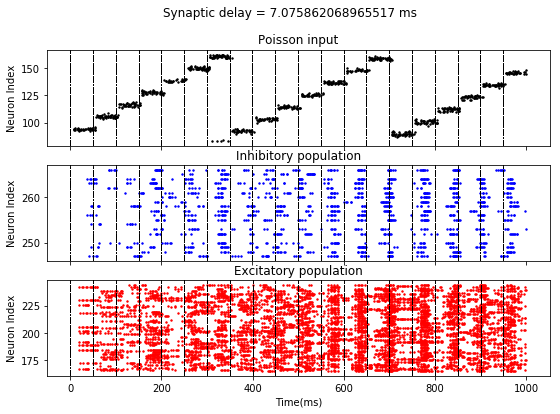

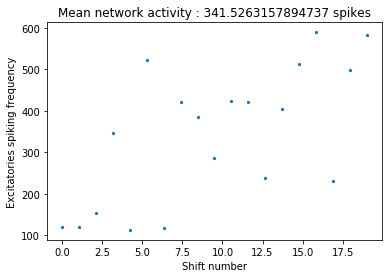

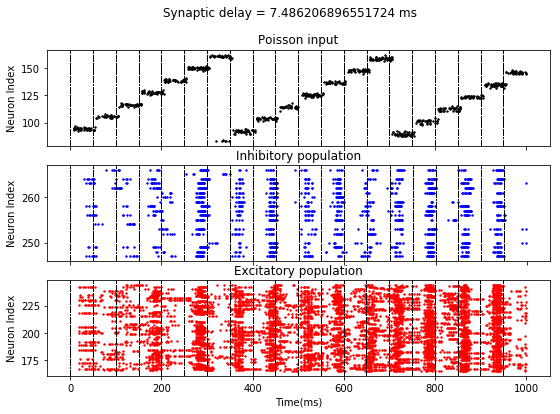

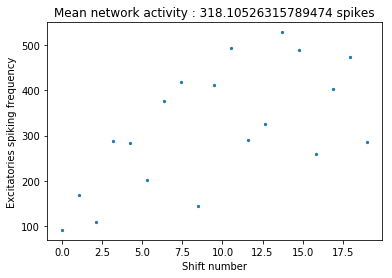

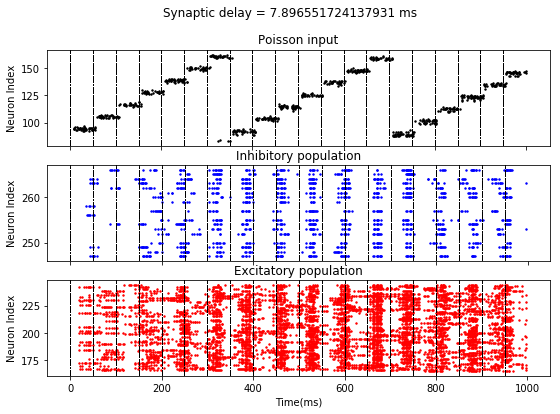

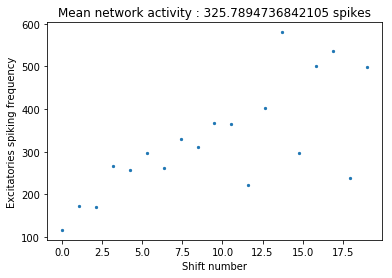

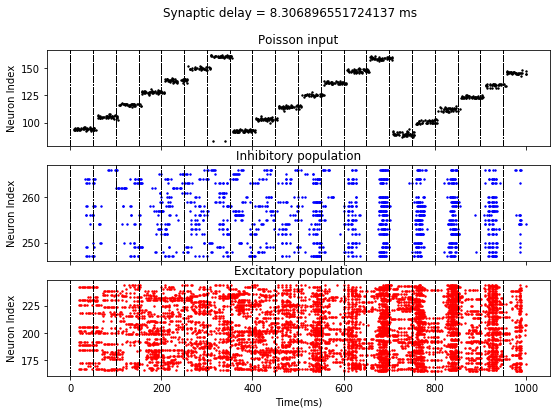

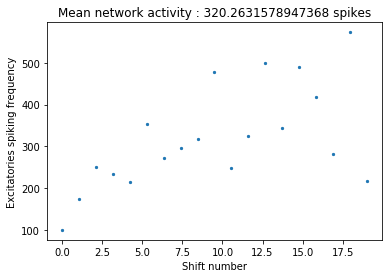

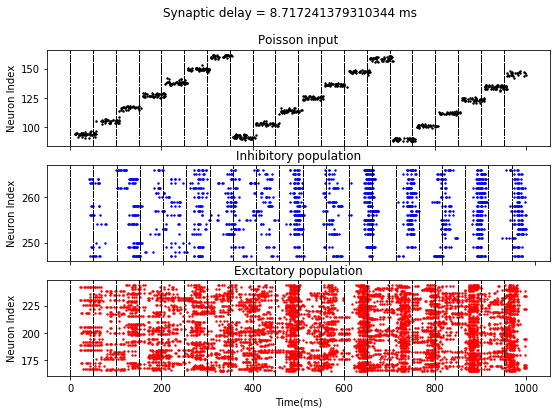

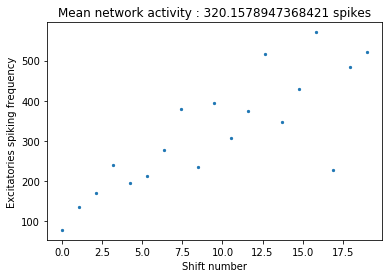

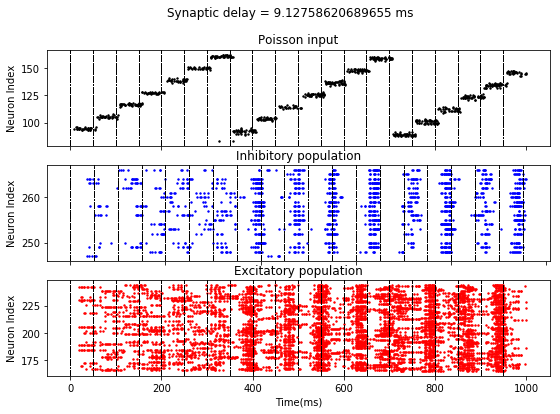

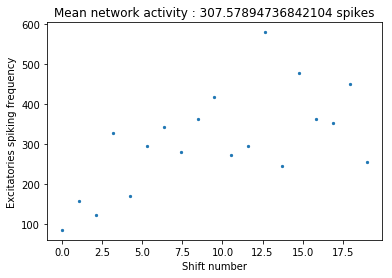

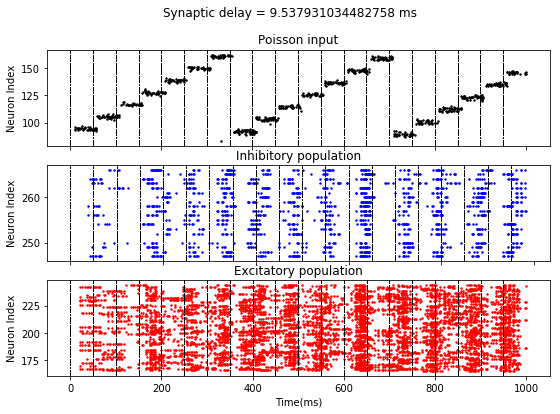

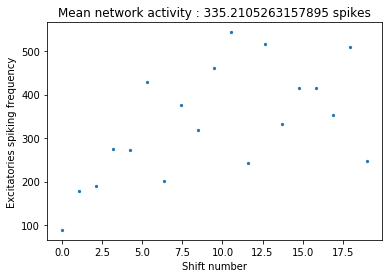

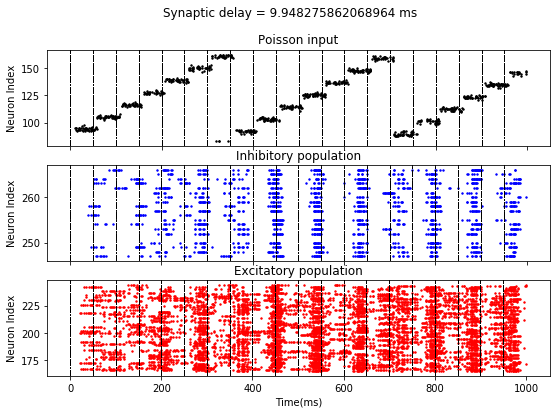

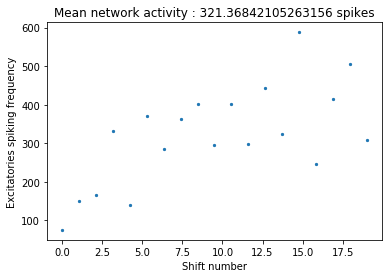

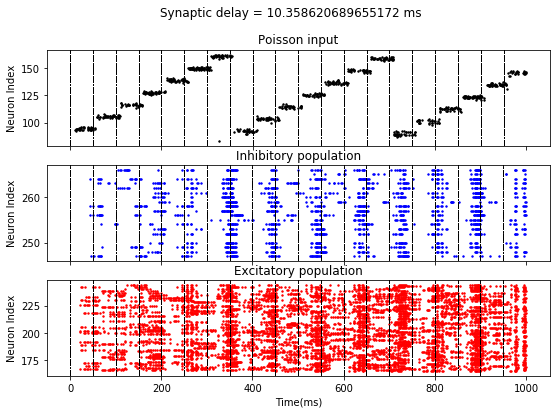

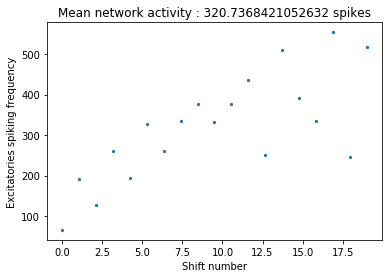

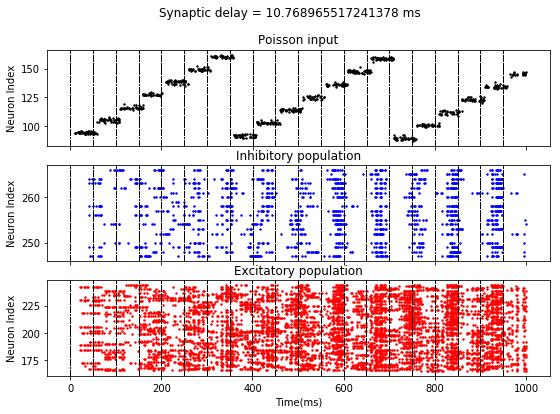

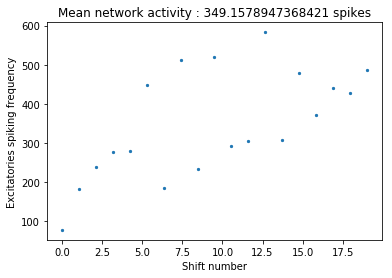

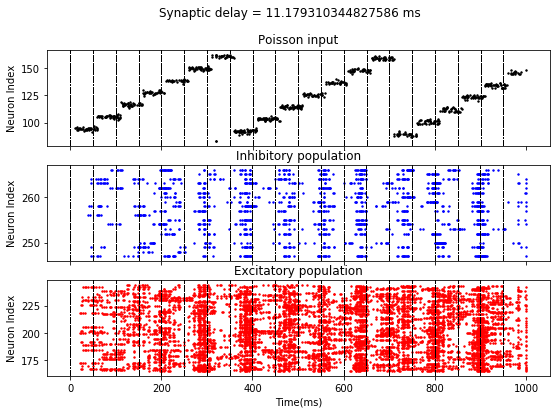

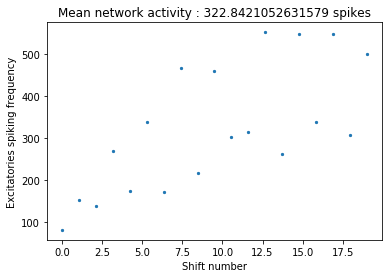

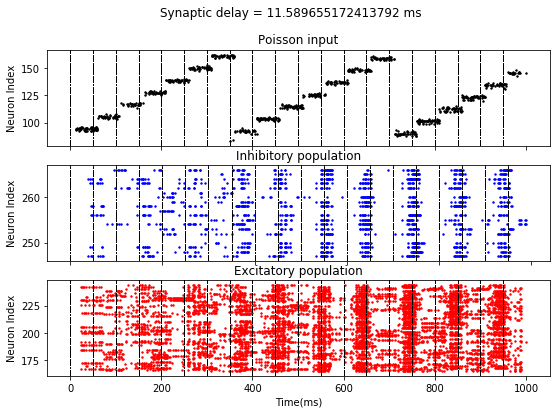

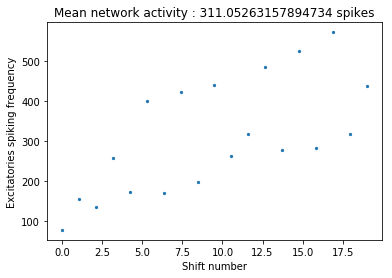

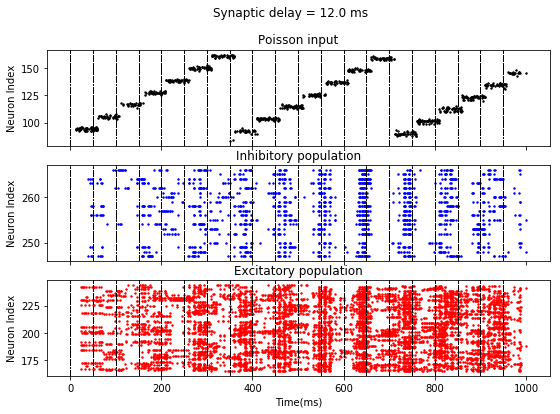

In [7]:
from tqdm import tqdm
scan = np.linspace(.1,12,30)

mean_spiking = [] #list of mean firing rate per scan
err_spiking = [] #list of standard deviation for mean firing rate per scan
full_spiking = [] #list of firing rate per shift per scan, this is a list of list

for i in scan :
    params = Net_Parameters(ring = True, recurrent = True, comult = 3)
    params.sim_params.update({'nb_neurons' : 100,
                              'simtime': 1000,
                            'nb_shifts' : 20,
                            'p' : .8,
                            'b_input' : 5.,
                            'angle_input': 50,
                            's_input_exc' : 10, #(ms) approx of delay retina to cortex in cats
                            's_input_inh' : 10,
                            's_exc_inh'   : i,
                            's_inh_exc'   : i,
                            's_exc_exc'   : i,
                            's_inh_inh'   : i,
                            'sigma' : .5})
    RNN = RNN_Simulation(sim_params = params.sim_params, inh_params = params.inh_params, 
                         exc_params = params.exc_params ,verbose = False)
                             
    E = RNN.E_neurons.get_data().segments[0]
    I = RNN.I_neurons.get_data().segments[0]
    P = RNN.P_neurons.get_data().segments[0]
    
    total_shift_spikes = 0
    ys = []
    #for each shift of the input angle
    for shift in RNN.shift_times[1:-1] :
        
        shift_spikes = []
        #for each neuron in the population
        for train in range(len(E.spiketrains)): 
            #Spike times for a single neuron 
            etrain = E.spiketrains[train]
            earr = np.asarray(etrain)
            #append spikes that happened before the current shift 
            for a in earr :
                if a < shift : shift_spikes.append(a)
            #print(shift_spikes)
        
        if RNN.verbose : print('A shift occured at  %s s, during which the network spiked %s times' % 
                               (shift,(len(shift_spikes)-total_shift_spikes)))
        
        ys.append((len(shift_spikes)-total_shift_spikes))
        total_shift_spikes = len(shift_spikes)
            
    plt.scatter(np.linspace(0, len(RNN.shift_times[1:-1]), len(RNN.shift_times[1:-1])), ys, s = 5)
    full_spiking.append(ys)
    
    plt.xlabel('Shift number')
    plt.ylabel('Excitatories spiking frequency')
    plt.title('Mean network activity : %s spikes' % np.mean(ys))
    mean_spiking.append(np.mean(ys))
    err_spiking.append(np.std(ys))
    
    plotter = PlotTwist()
    fig, axs = plotter.VanillaRasterPlot(title = 'Synaptic delay = %s ms'% i,
                              SpikesP = P, SpikesE = E, SpikesI = I,
                          markersize = 2, figsize = (9,6),shifts = RNN.shift_times[0:-1])
    plt.pause(.1)
    
    if i == scan[0] or i == scan[-1]:
        fig.savefig('./figs/2018_10_08_RingSTDP_delay_%s_ms.pdf' % i, format = 'pdf', dpi = 200)

Text(0.5, 0, 'Delay (ms)')

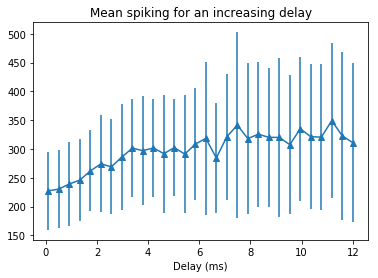

In [8]:
plt.errorbar(scan,mean_spiking, err_spiking, marker = '^')
plt.title('Mean spiking for an increasing delay')
plt.xlabel('Delay (ms)')

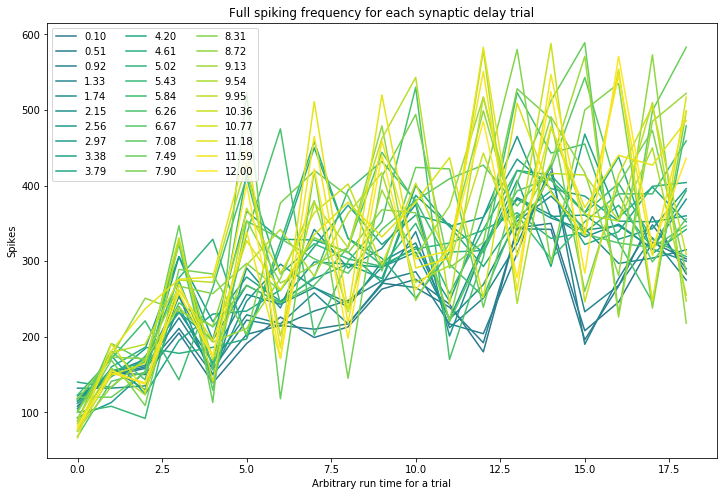

In [9]:
plt.figure(figsize = (12,8))
color=iter(plt.cm.viridis(np.linspace(.4, 1, len(full_spiking))))

for i, run in enumerate(full_spiking) :
    plt.plot(run, label = '%.2f'%scan[i], color = next(color))
    plt.xlabel('Arbitrary run time for a trial')
    plt.ylabel('Spikes')
    plt.legend(ncol = 3, fontsize = 'medium')
    
plt.title('Full spiking frequency for each synaptic delay trial')
plt.savefig('./figs/2018_10_08_RingSTDP_full_trials.pdf', format = 'pdf', dpi = 200)